> Created on Sun Feb 23 09:36:24 2020 @author: Richie Bao-caDesign设计(cadesign.cn)__+updated on Thu Jan 13 21:11:03 2022 by Richie Bao 

## 2.8.2 天空视域因子计算与内存管理

### 2.8.2.1 天空视域因子（Sky View Factor，SVF）计算方法

天空视域因子用于描述三维空间形态的数值，是空间中某一点上可见天空与以该点为中心整个半球之间的比率。通常值趋近于1，表明视域开阔；趋近于0，则封闭。天空视域因子广泛应用于城市热岛效应，城市能力平衡，和城市小气候等相关的研究中。虽然QGIS等平台也提供有SVF计算工具，例如QGIS:SAGA:Sky View Factor，但是计算大尺度，高分辨率DSM栅格数据的SVF通常会溢出，且计算缺乏灵活性。因此有必要直接在python下定义SVF计算方法。利用DSM获取城市下垫面SVF的计算公式为：$SVF=1- \frac{  \sum_{i=1}^n sin   \gamma _{i}   }{n} $，其中$\gamma _{i}$为不同障碍物的高度角，$n$为搜索方向的数量。已知栅格单元的高度（DSM值），及障碍物的高度，以及观察点到障碍物的距离，可以通过三角函数计算$\gamma _{i}$值。

为最终实现基于DSM计算SVF的代码编写，首先通过自定义一个小数据量的数组（代表DSM栅格），根据上述计算过程编写代码，快速的实现和检验方法的可行性后，再将其迁移到最终定义的SVF计算的类中。SVF计算的基本参数包括观察点、基于观察点向四周环顾一周的视线数量及其距离半径（视距），每根视线等分的数量。程序中比较关键的代码行是计算不同点或位置的坐标值，并将其转换为基于栅格（数组）的相对坐标值（整数型）。前者直接使用三角函数方法计算，后者借助`scipy.ndimage.map_coordinates（）`方法实现。




> 参考文献：]段欣,胡德勇,曹诗颂,于琛,张亚妮.城区复杂下垫面天空视域因子参数化方法——以北京鸟巢周边地区为例[J].国土资源遥感,2019,31(03):29-35.

> Böhner, J., & Antonić, O. (2009). Chapter 8 Land-Surface Parameters Specific to Topo-Climatology. Geomorphometry - Concepts, Software, Applications, 195–226. doi:10.1016/s0166-2481(08)00008-1 

> Häntzschel, J., Goldberg, V., & Bernhofer, C. (2005). GIS-based regionalisation of radiation, temperature and coupling measures in complex terrain for low mountain ranges. Meteorological Applications, 12(1), 33–42. doi:10.1017/s1350482705001489 

In [45]:
import numpy as np

#A-配置基本参数
z_value=np.round(np.random.rand(10,10)*0.5,2) #生成栅格（矩阵、数组）的随机高程值
print("random z value:\n{}".format(z_value)) 
observation_spot=[4,4] #定义观察点
division_num=5 #视线等分的数量
sight_distance=3 #视线距离（视距）
sight_line_num=16 #环顾一周视线数

random z value:
[[0.06 0.37 0.26 0.06 0.48 0.42 0.11 0.35 0.08 0.31]
 [0.03 0.34 0.23 0.3  0.42 0.49 0.35 0.38 0.44 0.04]
 [0.25 0.23 0.39 0.26 0.2  0.03 0.3  0.43 0.15 0.43]
 [0.16 0.13 0.49 0.06 0.1  0.4  0.44 0.29 0.28 0.01]
 [0.12 0.28 0.42 0.31 0.08 0.01 0.03 0.15 0.46 0.48]
 [0.32 0.27 0.04 0.31 0.5  0.17 0.34 0.19 0.03 0.02]
 [0.17 0.46 0.05 0.19 0.   0.03 0.42 0.06 0.06 0.07]
 [0.26 0.21 0.22 0.21 0.39 0.14 0.1  0.32 0.45 0.12]
 [0.35 0.04 0.34 0.04 0.07 0.03 0.09 0.28 0.17 0.13]
 [0.03 0.07 0.16 0.5  0.41 0.15 0.36 0.48 0.05 0.16]]


angle_list=[0.0, 22.5, 45.0, 67.5, 90.0, 112.5, 135.0, 157.5, 180.0, 202.5, 225.0, 247.5, 270.0, 292.5, 315.0, 337.5]


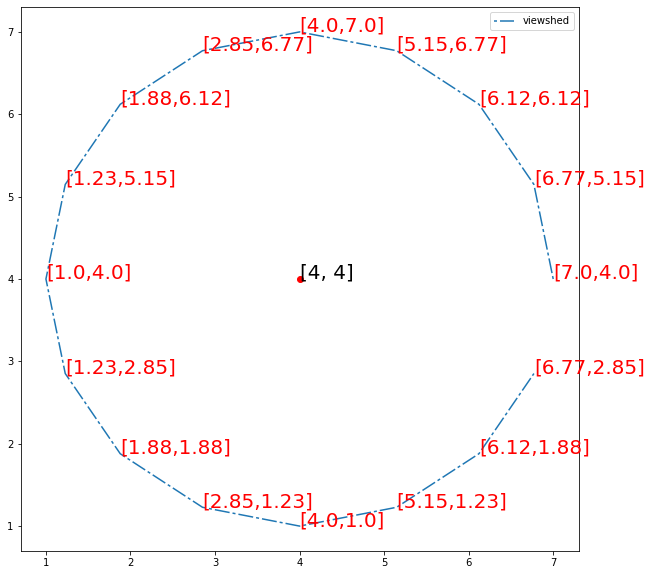

In [46]:
#B-等分视域，获取点坐标
def circle_division(observation_spot,sight_distance,sight_line_num):
    import math
    import matplotlib.pyplot as plt
    '''
    function - 给定观测位置点，视距和视线数量，等分圆，返回等分坐标点列表

    Paras:
        observation_spot - 观察点
        sight_distance - 视线距离（视距）
        sight_line_num - 环顾一周视线数     
    '''    
    angle_s=360/sight_line_num
    angle_list=[i*angle_s for i in range(sight_line_num)]
    print("angle_list={}".format(angle_list))
    coordi_list=[]
    for angle in angle_list:
        opposite=math.sin(math.radians(angle))*sight_distance
        adjacent=math.cos(math.radians(angle))*sight_distance
        coordi_list.append((adjacent+observation_spot[0],opposite+observation_spot[1]))
    
    fig, ax=plt.subplots(figsize=(10, 10))
    x=[i[0] for i in coordi_list]
    y=[i[1] for i in coordi_list]
    # Using set_dashes() to modify dashing of an existing line
    line1,=ax.plot(x, y, label='viewshed')
    line1.set_dashes([2, 2, 10, 2])  # 2pt line, 2pt break, 10pt line, 2pt break    
    ax.legend()
    
    for i in range(len(x)):
        ax.text(x[i],y[i],"[%s,%s]"%(round(x[i],2),round(y[i],2)),fontsize=20,color="r")
    ax.text(observation_spot[0],observation_spot[1],observation_spot,fontsize=20)
    ax.plot(observation_spot[0],observation_spot[1],"ro")
    plt.show()

    return coordi_list

coordi_list=circle_division(observation_spot,sight_distance,sight_line_num)

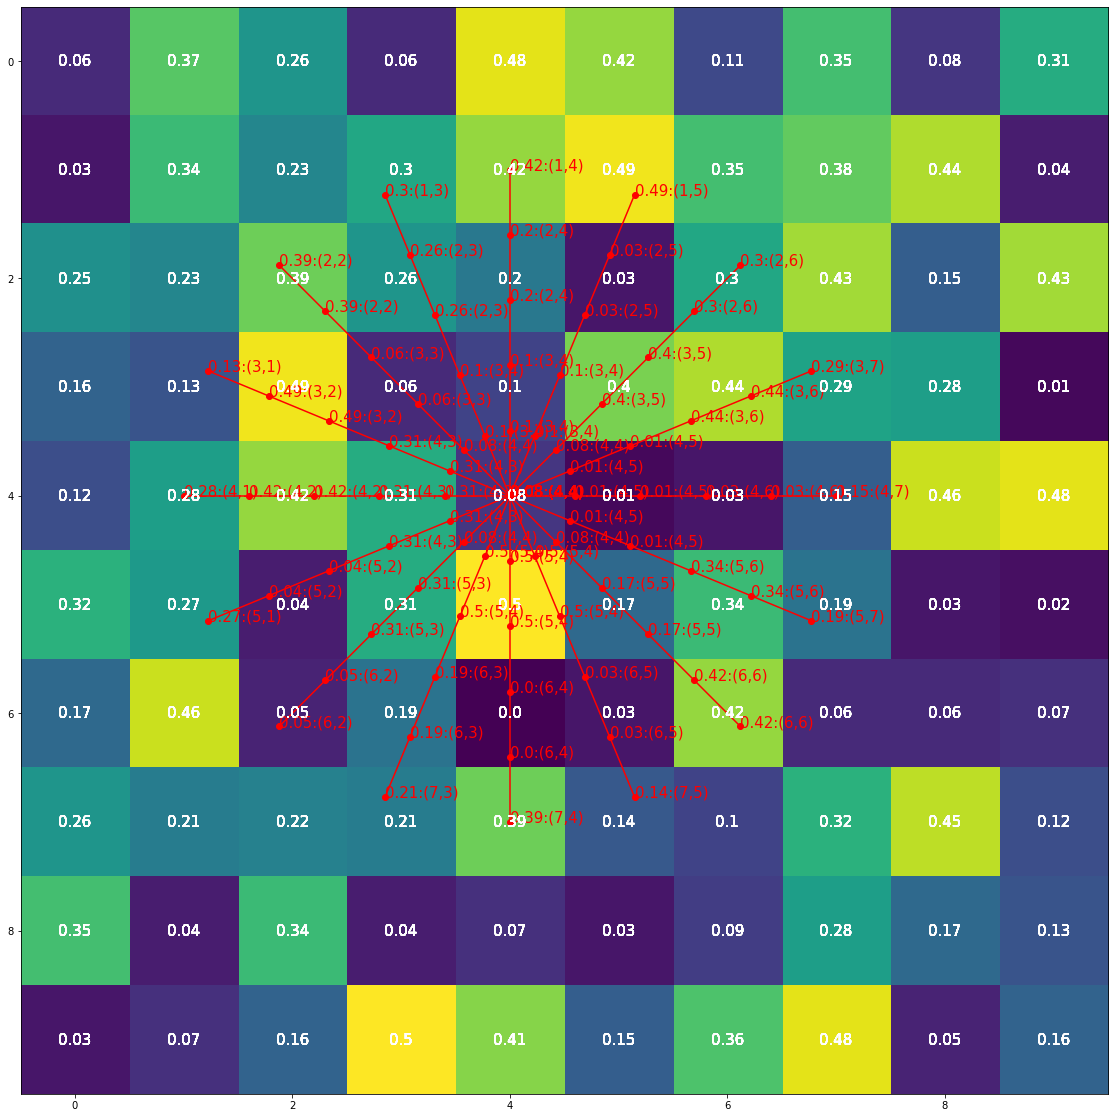

In [52]:
#C-根据视线提取栅格（数组）对应位置的高程（数组对应位置值），即批量提取截面高程数据
def line_profile(z_value,observation_spot,end_point,division_num):   
    import scipy.ndimage    
    '''
    function - 获取与视线相交单元栅格（数组对应位置）的栅格值（数组值）
    
    Paras:
        z_value - 高程数组
        observation_spot - 观察点
        end_point - 视线末尾点
        division_num - 视线等分的数量
    '''
    z=z_value    
    x0, y0=observation_spot
    x1, y1=end_point
    num=division_num+1
    x, y=np.linspace(x0, x1, num), np.linspace(y0, y1, num)
    
    # Extract the values along the line, using cubic interpolation
    zi=scipy.ndimage.map_coordinates(z, np.vstack((x,y)),cval=0,mode="nearest",order=0) #Map the input array to new coordinates by interpolation.    
    x_around=np.around(x).astype(int)
    y_around=np.around(y).astype(int)

    return zi,(x,y)

def combo_profile(z_value,observation_spot,coordi_list,division_num):
    import matplotlib.pyplot as plt
    '''
    function - 批量提取视线与高程数组（栅格）相交位置高程（数组对应位置值）
    
    Paras:
        z_value - 高程数组
        observation_spot - 观察点
        coordi_list - 坐标值列表（视线末端点）
        division_num - 视线等分的数量
    '''
    z_list=[]
    sub_coordi_list=[]
    for i in coordi_list:
        zi,sub_coordi=line_profile(z_value,observation_spot,i,division_num)
        z_list.append(zi)
        sub_coordi_list.append(sub_coordi)

    fig, axes = plt.subplots(nrows=1,figsize=z_value.shape*np.array([2]))
    axes.imshow(z_value)
    for n in range(len(sub_coordi_list)):
        x,y=sub_coordi_list[n]
        axes.plot(y,x, 'ro-')        
        axes.axis('image')

        for i in range(z_value.shape[0]):
            for j in range(z_value.shape[1]):
                axes.text(j, i, z_value[i, j],ha="center", va="center", color="w",size=15)
        for i in range(len(x)):
                axes.text(y[i],x[i],"%s:(%s,%s)"%(round(z_list[n][i],2),round(x[i]),round(y[i])),fontsize=15,color="r")
        
    plt.show()        
    return z_list

z_list=combo_profile(z_value,observation_spot,coordi_list,division_num)

In [59]:
#D-计算SVF
def SVF(sight_distance,division_num,z_list):
    import math
    '''
    function - 计算天空视域因子（Sky View Factor，SVF）
    
    Paras:
        sight_distance -视线距离（视距）
        division_num - 视线等分的数量
        z_list - 截面高程数组
    '''
    segment=sight_distance/division_num
    distance_list=[i*segment for i in range(division_num+1)]
    #print(distance_list)
    distance_list=distance_list[1:]
    
    sin_value_list=[]
    for i in z_list:
        sin_maximum=0
        for j in range(len(distance_list)):
            sin_temp=(i[j+1]-i[0])/math.sqrt(math.pow(distance_list[j],2)+math.pow(i[j+1]-i[0],2))
            if sin_temp>sin_maximum:
                sin_maximum=sin_temp
            else:pass
        sin_value_list.append(sin_maximum)   
    SVF_value=1-sum(sin_value_list)/len(z_list)
    print("SVF_value=%s"%SVF_value)
        
    return SVF_value

SVF_value=SVF(sight_distance,division_num,z_list)

SVF_value=0.7363503424243715


### 2.8.2.2 基于DSM计算SVF

上述SVF计算过程中使用了for循环，这将会大幅度增加计算时间，例如对于配置为：16G内存，可用约13G；Intel Core i7-8650U CPU @1.90GHz; 含大容量外置硬盘用于数据存储的条件下，（392，380）即148,960个值计算时长约为1min；（4428，4460）即19,748,880个值时为2hs。当计算数据量（栅格单元数）为3,119,035,612时(cell size=3×3)，for循环很难实现计算，因此必须转换为numpy数组形式逐次批量计算，避免逐个循环计算。其中核心的SVF计算方法（公式）并没有改变。最终区域DSM计算结果如图：

<a href=""><img src="./imgs/2_8_2_03.png" height='auto' width='auto' title="caDesign"></a>

在计算过程中，使用rasterio库Window方法切分栅格为多个子栅格逐个读取计算，减少单个栅格的SVF计算量，并逐一保存。当计算完所有子栅格后，将其合并为单独一个或者2-3个栅格（当一个栅格存储文件过大时）。使用切分为子栅格计算SVF，存在一个问题，子栅格边缘位置的单元因为缺失邻近栅格造成计算不准确。这时可以衡量计算机的硬件条件，尽量让子栅格尽量大，减少误差的位置数量。

In [2]:
class SVF_DSM:
    '''
    class - 由DSM栅格计算SVF（适用于高分辨率大尺度栅格运算）
    '''
    def __init__(self,dsm_fp,save_root,sight_distance,sight_line_num,division_num):
        self.dsm_fp=dsm_fp
        self.save_root=save_root
        self.sight_distance=sight_distance
        self.sight_line_num=sight_line_num
        self.division_num=division_num
        
    def raster_properties(self):
        import rasterio as rio
        '''
        function - 读取栅格，查看属性值，返回需要的属性(栅格总宽高)
        '''
        raster=rio.open(self.dsm_fp)
        print("type:",type(raster))
        print("transform:",raster.transform)
        print("[width,height]:", raster.width, raster.height)
        print("number of bands:",raster.count)
        print("bounds:",raster.bounds)
        print("driver:", raster.driver)
        print("no data values:",raster.nodatavals)    
        print("_"*50)        
        return raster.width, raster.height
    
    def divide_chunks(self,l,n):
        '''
        function - 递归分组列表数据
        '''         
        for i in range(0, len(l), n):  # looping till length l
            yield l[i:i + n]  
    
    def rasterio_windows(self,total_width,total_height,sub_width,sub_height):
        from rasterio.windows import Window
        '''
        function - 建立用于rasterio库分批读取一个较大raster数据的windows列表（尤其要处理较大单独的raster数据时，避免内存溢出）
        
        Paras:
            total_width - 栅格总宽
            total_height - 栅格总高
            sub_width - 切分的子栅格宽
            sub_height - 切分的子栅格高
        '''
        w_n=list(self.divide_chunks(list(range(total_width)), sub_width))
        h_n=list(self.divide_chunks(list(range(total_height)), sub_height))
        wins=[Window(w[0],h[0],len(w),len(h)) for h in h_n for w in w_n]
        print("raster windows amount:",len(wins))
        return wins  
    
    def array_coordi(self, raster_array):
        import numpy as np
        '''
        function - 计算栅格单元（数组）的相对坐标
        '''
        relative_cell_coords=np.indices(raster_array.shape)
        relative_cell_coords2D=np.stack(relative_cell_coords,axis=2).reshape(-1,2)
        del relative_cell_coords
        #print(relative_cell_coords2D)                              
        return relative_cell_coords2D    
    
    def circle_division(self,observation_spot):
        import numpy as np
        '''
        function - 给定观测位置点，视距和视线数量，等分圆，返回等分坐标点数组
        '''
        angle_s=360/self.sight_line_num
        angle_array=np.array([i*angle_s for i in range(self.sight_line_num)],dtype=np.float32)
        opposite=np.sin(np.radians(angle_array),dtype=np.float16)*self.sight_distance
        opposite=opposite.astype(np.float32)
        yCoordi=np.add(opposite,observation_spot[:,1].reshape(-1,1),dtype=np.float32)
        del opposite

        adjacent=np.cos(np.radians(angle_array),dtype=np.float16)*self.sight_distance
        xCoordi=np.add(adjacent,observation_spot[:,0].reshape(-1,1),dtype=np.float32)
        del adjacent,angle_array

        coordi_array=np.stack((xCoordi,yCoordi),axis=-1)
        return coordi_array    
    
    def line_profile(self,z_value,observation_spot,end_point): 
        import numpy as np
        import scipy.ndimage 
        '''
        function - 获取与视线相交单元栅格（数组对应位置）的栅格值（数组值），即数组延直线截面提取单元值
        
        Paras:
            z_value - DSM栅格（含高程信息）
            observation_spot - 观察点数组
            end_point -  视线末尾点数组
        '''    
        num=self.division_num+1

        x0=observation_spot[:,0].reshape(-1,1)
        x1=end_point[:,:,0]
        x=np.linspace(x0, x1, num,dtype=int) #可以不用修改数组类型。出于内存优化考虑,会加快后续np.stack计算速度
        del x0,x1

        y0=observation_spot[:,1].reshape(-1,1)  
        y1=end_point[:,:,1]
        y=np.linspace(y0, y1, num,dtype=int)
        del y0,y1

        xStack=np.stack(x,axis=-1)    
        yStack=np.stack(y,axis=-1)
        del x,y

        zi=scipy.ndimage.map_coordinates(z_value,[xStack,yStack],cval=0,mode="nearest",order=0) #根据数组索引值，提取实际值
        del xStack,yStack

        return zi    
    
    def SVF(self,z_list):
        import numpy as np
        '''
        function - 计算天空视域因子（Sky View Factor，SVF）
        '''
        segment=self.sight_distance/self.sight_line_num
        distance_list=np.array([i*segment for i in range(self.sight_line_num+1)],dtype=np.float32)
        distance_list=distance_list[1:]
        distance_list=np.expand_dims(distance_list,axis=1)
        z_list_sub=z_list[:,:,1:]
        z_list_origin=z_list[:,:,0]
        
        sin_values=np.true_divide(np.subtract(z_list_sub,np.expand_dims(z_list_origin, axis=2)),np.sqrt(np.add(np.power(distance_list,2),np.power(np.subtract(z_list_sub,np.expand_dims(z_list_origin, axis=2)),2))))
        sin_max_value=np.amax(sin_values,axis=2)
        del sin_values
        SVF_value=1-np.true_divide(np.sum(sin_max_value, axis=1),sin_max_value.shape[-1])

        return SVF_value.astype(np.float32)    
    
    def svf_wins(self, wins_list):
        from tqdm import tqdm
        import rasterio as rio
        import datetime,gc,os
        from rasterio.windows import Window
        import warnings    
        #suppress warnings
        warnings.filterwarnings('ignore')
        '''
        function - 计算SVF的主程序，并保存SVF子栅格文件
        '''
        i=0
        for win in tqdm(wins_list): 
            with rio.open(self.dsm_fp,"r+") as src:
                src.nodata=-1
                w=src.read(1, window=win) 
                profile=src.profile
                win_transform=src.window_transform(win)  
                
            '''计算部分'''   
            #print(w.shape)
            relative_cell_coords2D=self.array_coordi(w)
            
            #B-等分视域，获取点坐标
            a_T=datetime.datetime.now()
            coordi_array=self.circle_division(relative_cell_coords2D) 
            b_T= datetime.datetime.now()
            print("circle_division-time span:{}".format( b_T-a_T))
            gc.collect()
            
            #C-根据视线提取栅格（数组）对应位置的高程（数组对应位置值），即批量提取截面高程数据
            c_T=datetime.datetime.now()
            zi=self.line_profile(w,relative_cell_coords2D,coordi_array)
            d_T=datetime.datetime.now()
            print("lineProfile-time span:{}".format(d_T-c_T))
            gc.collect()
            del coordi_array  
            
            #D-计算SVF
            e_T=datetime.datetime.now()
            SVF_value=self.SVF(zi)
            f_T=datetime.datetime.now()
            print("SVF-time span:{}".format(d_T-c_T))
            gc.collect()
            del zi
        
            profile.update(
                    width=win.width, 
                    height=win.height,
                    count=1,
                    transform=win_transform,
                    compress='lzw',
                    dtype=rio.float32
                    )            
            with rio.open(os.path.join(self.save_root,"SVF3_%d.tif"%i), 'w', **profile) as dst:
                dst.write(SVF_value.reshape(w.shape), window=Window(0,0,win.width,win.height), indexes=1)     
            del SVF_value
            g_T=datetime.datetime.now()
            print("total-time span:{}".format(g_T-a_T))
            i+=1 
            
            break 

dsm_fp=r"G:\data\DSM_pixel_3.tif"
save_root=r"G:\data\data_processed\SVF\SFV3_A"  
#A-SVF配置基本参数
raster_resolution=3 #计算栅格的分辨率    
sight_distance=100*raster_resolution #扫描半径
sight_line_num=8 #扫描截面数量36
division_num=30 #每条扫描线的等分数量  50

SVF=SVF_DSM(dsm_fp,save_root,sight_distance,sight_line_num,division_num)   
total_width,total_height=SVF.raster_properties()
print("total_width={},total_height={}".format(total_width,total_height))

sub_width,sub_height=3000,3000 #3000,3000
wins_list=SVF.rasterio_windows(total_width,total_height,sub_width,sub_height)
print("windows example:{}".format(wins_list[:5]))

SVF.svf_wins(wins_list)

type: <class 'rasterio.io.DatasetReader'>
transform: | 3.00, 0.00, 1075000.00|
| 0.00,-3.00, 1987501.00|
| 0.00, 0.00, 1.00|
[width,height]: 46667 60834
number of bands: 1
bounds: BoundingBox(left=1075000.0, bottom=1805000.0, right=1215001.0, top=1987501.0)
driver: GTiff
no data values: (-1.0,)
__________________________________________________
total_width=46667,total_height=60834
raster windows amount: 336
windows example:[Window(col_off=0, row_off=0, width=3000, height=3000), Window(col_off=3000, row_off=0, width=3000, height=3000), Window(col_off=6000, row_off=0, width=3000, height=3000), Window(col_off=9000, row_off=0, width=3000, height=3000), Window(col_off=12000, row_off=0, width=3000, height=3000)]


  0%|          | 0/336 [00:00<?, ?it/s]

circle_division-time span:0:00:00.658197
lineProfile-time span:0:03:49.709210
SVF-time span:0:03:49.709210


  0%|          | 0/336 [04:54<?, ?it/s]

total-time span:0:04:52.874828


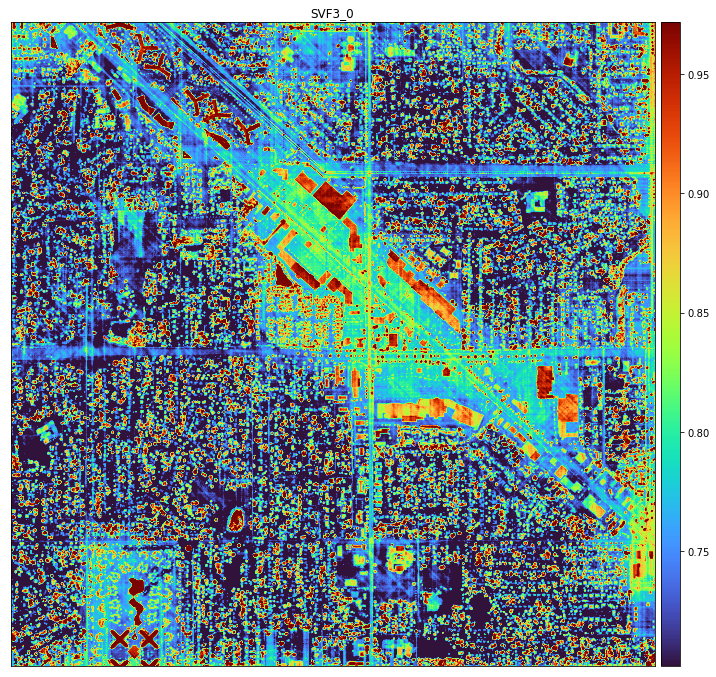

In [4]:
import util_A
SVF3_0_fp=r"G:\data\data_processed\SVF\SFV3_A\SVF3_0.tif"
util_A.raster_show(SVF3_0_fp,title='SVF3_0')

### 2.8.2.3 内存管理

常规电脑的硬件配置通常有个限度。因此在处理大数据时，可能因为数据量、计算量造成内存溢出。例如`np.arange(6000000000,dtype=np.float64)`数组，预计占用45.7GB，如果内存小于该值，将溢出。6,000,000,000数据量，相当于77459.6m × 77459.6m的城市区域。如果在这个过程中，存在其它计算，则将大幅度增加所用内存，因此如何管理内存与释放内存，在大数据处理过程中显得尤为重要。

* 对较大数据进行数据分析的几点建议：

1. 避免使用for循环，尽量使用array(numpy)直接数组间计算或者使用DataFrame(pandas)，可以大幅度增加计算速度，但会占用较大内存，需使用内存管理/减压工具处理；
2. 数据分批处理，并保存于硬盘中。逐一处理完后，读取所有文件进行后续处理。需平衡分批与一次性数组计算量，每次数组大计算速度快，但占用内存多；如果增加批次，则会降低单次数组量，但会增加计算时间；
3. 如果不必要，不需保存中间过渡的大数组。通常应用后，del释放内存，仅保留和存储必要的计算结果或中间结果。大数组尽量使用h5py保存于硬盘中。并尽量避免使用`np.save`工具，该工具保存的数据占据磁盘空间较大；
4. 大数据处理过程中，尽量避免使用matplotlib查看数据。只有必要分析时，再单独处理；
5. 为了减缓内存，数据及过程数据存储于大的硬盘中。根据自身数据大小，可以准备高容量的外置硬盘使用。另固态硬盘具有更快的读写速度；
6. 使用虚拟内存，可以有效缓解内存压力；
7. 有必要使用GPU计算，尤其训练深度学习模型；
8. 优化算法。



#### 1）[psutil](https://psutil.readthedocs.io/en/latest/)

psutil用于在python中检索有关正在运行的进程和系统利用率(CPU、内存、磁盘、网络、传感器)的信息。主要用于系统监控、分析、限制进程资源和管理运行的进程。（更详细的内容需查看[psutil文档](https://psutil.readthedocs.io/en/latest/)）

In [21]:
import psutil
print("cpu_count:{}".format(psutil.cpu_count(logical=True))) #当配置logical=True时，返回logical CPUs的数量。同os.cpu_count()

mem=psutil.virtual_memory()
print("virtual_memory:{}".format(mem)) #以元组的形式返回系统内存使用的统计信息
THRESHOLD=100 * 1024 * 1024  # 100MB
if mem.available <= THRESHOLD:
    print("warning")
    
print("disk_partitions:{}".format(psutil.disk_partitions())) #返回挂载的磁盘分区（mounted partitions）有关信息
print("disk_usage:{}".format(psutil.disk_usage('/'))) #返回包含给定路径的分区磁盘使用统计信息，包含以字节表示的总空间、已用空间和空闲空间，及使用百分比

cpu_count:16
virtual_memory:svmem(total=51410481152, available=38877888512, percent=24.4, used=12532592640, free=38877888512)
disk_partitions:[sdiskpart(device='C:\\', mountpoint='C:\\', fstype='NTFS', opts='rw,fixed'), sdiskpart(device='E:\\', mountpoint='E:\\', fstype='exFAT', opts='rw,fixed'), sdiskpart(device='F:\\', mountpoint='F:\\', fstype='NTFS', opts='rw,fixed'), sdiskpart(device='G:\\', mountpoint='G:\\', fstype='exFAT', opts='rw,fixed')]
disk_usage:sdiskusage(total=511101923328, used=473427255296, free=37674668032, percent=92.6)


#### 2）[h5py](https://www.h5py.org/)

HDF5(python,h5py) 是HDF5二进制数据格式的python接口。HDF5可以存储大量数值数据（numerical data），并可以轻松地用NumPy操作这些数据。例如，可以将存储在磁盘上的tb级数据集切片；成千上万的数据集可以存储在一个文件中，根据需要进行分类和标记。 （更详细的内容需查看[h5py文档](https://docs.h5py.org/en/stable/)）

In [73]:
import h5py,os
import numpy as np

# 建立hdf5文件路径
data_save_root=r"G:\data\data_processed\h5py"
hdf5_fp=os.path.join(data_save_root,"h5py_experi.hdf5")
if os.path.exists(hdf5_fp):
    os.remove(hdf5_fp)
else:
    print("Can note delete the file as it does not exists. to built a new one!")

#生成随机的实验数据
data_a=np.random.rand(10000,10000)
data_b=np.random.rand(10000,10000)
data_c=np.random.rand(10000,10000)  
data_d=np.random.rand(10000,10000)
data_e=np.random.randint(100,size=(100,100))

#用f=h5py.File()和f.close()，打开写入数据文件，并关闭文件
f=h5py.File(hdf5_fp, "w")  #create a file by setting the mode to w when the File object is initialized. Some other modes are a (for read/write/create access), and r+ (for read/write access). 
dset_a=f.create_dataset("dataset_a",data=data_a)
dset_b=f.create_dataset("dataset_b",data=data_b)
print("dset_a name={}; dset_b name={}".format(dset_a.name,dset_b.name))
print("f name={}".format(f.name)) #可以看作默认组（group）
f.close()

#可以用with h5py.File() as f:的方法，读写数据
with h5py.File(hdf5_fp, "a") as f:
    #建立子组/群（subgroup），子组中可以写入若干数据集(dataset)
    grp=f.create_group("subgroup")
    print("grp(group) name={}".format(grp.name))    
    dset2=grp.create_dataset("dataset_c", (10000,10000), dtype='f',data=data_c)    
    print("dset2 name={}".format(dset2.name))
    grp.create_dataset("dataset_d", data=data_d)   
    print("subgroup keys={}".format(list(f["subgroup"].keys())))    

with h5py.File(hdf5_fp, "a") as f:    
    #直接建立子组和子组下的数据集
    dset3=f.create_dataset('subgroup2/dataset_three', (100,100), dtype='i',data=data_e)
    dset3.attrs["attri_a"]="attri_A" #可以配置属性字段
    dset3.attrs["attri_b"]="attri_B"
    print("dset3 name={}".format(dset3.name))    
    print("dset3.attrs[\"attri_a\"]={}".format(dset3.attrs["attri_a"]))
    print("dset3.attrs list={}".format(list(dset3.attrs)))

dset_a name=/dataset_a; dset_b name=/dataset_b
f name=/
grp(group) name=/subgroup
dset2 name=/subgroup/dataset_c
subgroup keys=['dataset_c', 'dataset_d']
dset3 name=/subgroup2/dataset_three
dset3.attrs["attri_a"]=attri_A
dset3.attrs list=['attri_a', 'attri_b']


In [94]:
def visit_func(name, node) :
    '''
    function - 打印HDF5文件数据集和子组信息
    '''
    print ('Full object pathname is:', node.name)
    if isinstance(node, h5py.Group) :
        print ('Object:', name, 'is a Group\n')
    elif isinstance(node, h5py.Dataset) :
        print ('Object:', name, 'is a Dataset\n')
    else :
        print ('Object:', name, 'is an unknown type\n')    
        
def get_dataset_keys(f):
    '''
    function - 返回HDF5文件数据集路径（包括子组内数据集）
    '''
    keys=[]
    f.visit(lambda key : keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
    return keys        

#查看HDF5文件，并读取数据集
with h5py.File(hdf5_fp, "r+") as f:     
    print("f_keys={}".format(list(f.keys())))
    print("_"*50)
    datasets_description=f.visititems(visit_func)
    
    dataset_keys=get_dataset_keys(f)
    print("dataset keys={}".format(dataset_keys))
    
    dataset_three=f.get(dataset_keys[-1])[:]
print("_"*50)    
print("'subgroup2/dataset_three' array:\n{}".format(dataset_three))        

f_keys=['dataset_a', 'dataset_b', 'subgroup', 'subgroup2']
__________________________________________________
Full object pathname is: /dataset_a
Object: dataset_a is a Dataset

Full object pathname is: /dataset_b
Object: dataset_b is a Dataset

Full object pathname is: /subgroup
Object: subgroup is a Group

Full object pathname is: /subgroup/dataset_c
Object: subgroup/dataset_c is a Dataset

Full object pathname is: /subgroup/dataset_d
Object: subgroup/dataset_d is a Dataset

Full object pathname is: /subgroup2
Object: subgroup2 is a Group

Full object pathname is: /subgroup2/dataset_three
Object: subgroup2/dataset_three is a Dataset

dataset keys=['dataset_a', 'dataset_b', 'subgroup/dataset_c', 'subgroup/dataset_d', 'subgroup2/dataset_three']
__________________________________________________
'subgroup2/dataset_three' array:
[[98 15 44 ... 51  9 14]
 [89 98 29 ... 29 91 57]
 [45 54 54 ... 92 52 45]
 ...
 [12 92  2 ... 45 86 61]
 [ 9 36 42 ... 57 90 75]
 [33 62 23 ... 31 14 98]]


#### 3）[PyTables](https://pypi.org/project/tables/)

PyTables是一个用于管理分层数据集的库，旨在高效、轻松地处理极其大量的数据。PyTables是在HDF5库的基础上构建的，使用Python语言和NumPy库，可以交互式浏览、处理和搜索大量数据。该库优化内存和磁盘资源，使得数据占用的空间得以优化。（更详细的内容需查看[PyTables文档](https://www.pytables.org/usersguide/tutorials.html)）

> 下述代码迁移于[PyTables的GitHub仓库](https://github.com/PyTables/PyTables/blob/master/examples/tutorial1-1.py)。对于DataFrame(pandas)可以使用DataFrame.to_hdf()和pandas.read_hdf()来读写HDF5文件。pandas是使用PyTables完成读写HDF5文件。

In [23]:
import tables as tb
import numpy as np

# Define a user record to characterize some kind of particles
class Particle(tb.IsDescription):
    name = tb.StringCol(16)     # 16-character String
    idnumber = tb.Int64Col()    # Signed 64-bit integer
    ADCcount = tb.UInt16Col()   # Unsigned short integer
    TDCcount = tb.UInt8Col()    # unsigned byte
    grid_i = tb.Int32Col()      # integer
    grid_j = tb.Int32Col()      # integer
    pressure = tb.Float32Col()  # float  (single-precision)
    energy = tb.Float64Col()    # double (double-precision)

print('-**-**-**-**-**-**- file creation  -**-**-**-**-**-**-**-') 
# The name of our HDF5 filename
filename = "G:\data\data_processed\h5py\pytables_experi.h5"
# Open a file in "w"rite mode
h5file = tb.open_file(filename, mode="w", title="pytables_experi")
print("Creating file:", filename)

print()
print('-**-**-**-**-**- group and table creation  -**-**-**-**-**-**-**-')
# Create a new group under "/" (root)
group = h5file.create_group("/", 'detector', 'Detector information')
print("Group '/detector' created")

# Create one table on it
table = h5file.create_table(group, 'readout', Particle, "Readout example")
print("Table '/detector/readout' created")

# Print the file
print(h5file)
print(repr(h5file))

# Get a shortcut to the record object in table
particle = table.row

# Fill the table with 10 particles
for i in range(10):
    particle['name'] = 'Particle: %6d' % (i)
    particle['TDCcount'] = i % 256
    particle['ADCcount'] = (i * 256) % (1 << 16)
    particle['grid_i'] = i
    particle['grid_j'] = 10 - i
    particle['pressure'] = float(i * i)
    particle['energy'] = float(particle['pressure'] ** 4)
    particle['idnumber'] = i * (2 ** 34)
    particle.append()

# Flush the buffers for table
table.flush()

print()
print('-**-**-**-**-**-**- table data reading & selection  -**-**-**-**-**-')
# Read actual data from table. We are interested in collecting pressure values on entries where TDCcount field is greater than 3 and pressure less than 50
xs = [x for x in table.iterrows() if x['TDCcount'] > 3 and 20 <= x['pressure'] < 50]
pressure = [x['pressure'] for x in xs ]
print("Last record read:")
print(repr(xs[-1]))
print("Field pressure elements satisfying the cuts:")
print(repr(pressure))

# Read also the names with the same cuts
names = [x['name'] for x in table.where("""(TDCcount > 3) & (20 <= pressure) & (pressure < 50)""")]
print("Field names elements satisfying the cuts:")
print(repr(names))

print()
print('-**-**-**-**-**-**- array object creation  -**-**-**-**-**-**-**-')
print("Creating a new group called '/columns' to hold new arrays")
gcolumns = h5file.create_group(h5file.root, "columns", "Pressure and Name")

print("Creating an array called 'pressure' under '/columns' group")
h5file.create_array(gcolumns, 'pressure', np.array(pressure),"Pressure column selection")
print(repr(h5file.root.columns.pressure))

print("Creating another array called 'name' under '/columns' group")
h5file.create_array(gcolumns, 'name', names, "Name column selection")
print(repr(h5file.root.columns.name))

print("HDF5 file:")
print(h5file)

# Close the file
h5file.close()
print("File '" + filename + "' created")

-**-**-**-**-**-**- file creation  -**-**-**-**-**-**-**-
Creating file: G:\data\data_processed\h5py\pytables_experi.h5

-**-**-**-**-**- group and table creation  -**-**-**-**-**-**-**-
Group '/detector' created
Table '/detector/readout' created
G:\data\data_processed\h5py\pytables_experi.h5 (File) 'pytables_experi'
Last modif.: 'Sat Jan 15 14:34:30 2022'
Object Tree: 
/ (RootGroup) 'pytables_experi'
/detector (Group) 'Detector information'
/detector/readout (Table(0,)) 'Readout example'

File(filename=G:\data\data_processed\h5py\pytables_experi.h5, title='pytables_experi', mode='w', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) 'pytables_experi'
/detector (Group) 'Detector information'
/detector/readout (Table(0,)) 'Readout example'
  description := {
  "ADCcount": UInt16Col(shape=(), dflt=0, pos=0),
  "TDCcount": UInt8Col(shape=(), dflt=0, pos=1),
  "energy": Float64Col(shape=(), dflt=0.0, p

#### 4）[memory_profiler](https://pypi.org/project/memory-profiler/)

memory_profiler 用于监控进程的内存消耗，及逐行分析python程序的内存消耗。（更详细的内容需查看[memory_profiler文档](https://pypi.org/project/memory-profiler/)）

```python
@profile
def my_func():
    a = [1] * (10 ** 6)
    b = [2] * (2 * 10 ** 7)
    del b
    return a

if __name__ == '__main__':
    my_func()
```

将上述官网提供的示例程序，单独保存为.py文件后，在终端执行`mprof run <executable>`，以及`mprof plot`，可以获取如下图表：

<a href=""><img src="./imgs/2_8_2_01.png" height='auto' width='auto' title="caDesign"></a>

执行`python -m memory_profiler <executable>`，可以逐行观察计算所占内存量，用于观察代码优化结果。计算结果如下：

```
Line #    Mem usage    Increment  Occurences   Line Contents
============================================================
     1   40.832 MiB   40.832 MiB           1   @profile
     2                                         def my_func():
     3   48.465 MiB    7.633 MiB           1       a = [1] * (10 ** 6)
     4  201.055 MiB  152.590 MiB           1       b = [2] * (2 * 10 ** 7)
     5   48.465 MiB -152.590 MiB           1       del b
     6   48.465 MiB    0.000 MiB           1       return a
```